In [45]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
from uncertainties import ufloat, unumpy
from scipy.odr import ODR, Model, RealData

### Data Loader

In [43]:
def load_data(path):
    np.set_printoptions(suppress=True, precision=10)
    data_list = glob.glob(path)
    data_np = []
    for i in data_list:
        data = pd.read_csv(i, sep=',')
        data_np.append(data.to_numpy())
    return data_np

In [44]:
path_planck = '/Users/danielmiksch/Library/CloudStorage/OneDrive-Persönlich/Uni/C-Praktikum/C45/Planck/*.csv'
data365, data405 = load_data(path=path_planck)

# Measuring the Planck constant

## Piecewise fitting function

In [79]:
def exp(p, x):
    A, B, C, U = p
    return A+B*(np.exp(C*(x-U)-1))

def lin(p, x):
    A, M, U = p
    return A+M*(x-U)

def calc_sx(data, range):
    return 0.00025*abs(data)+0.00005*range


def piecewise(x, y, sx, sy, threshold, betaLin, betaExp, mark=False, print_beta=False):
    modelExp = Model(exp)
    modelLin = Model(lin)
    dataLin = RealData(x[:threshold], y[:threshold], sx=sx[:threshold], sy=sy[:threshold])
    dataExp = RealData(x[threshold:], y[threshold:], sx=sx[threshold:], sy=sy[threshold:])
    odrExp = ODR(dataExp, modelExp, beta0=betaExp)
    odrLin = ODR(dataLin, modelLin, beta0=betaLin)
    outputExp = odrExp.run()
    outputLin = odrLin.run()
    if print_beta:
        print('Linear:')
        outputLin.pprint()
        print()
        print('Exponential:')
        outputExp.pprint()
    if mark:
        x_plot = np.linspace(np.min(x), np.max(x), 1000)
        plt.scatter(x[:threshold], y[:threshold], c='red')
        plt.scatter(x[threshold:], y[threshold:], c='blue')
        plt.plot(x_plot, exp(outputExp.beta, x_plot), c='blue')
        plt.plot(x_plot, lin(outputLin.beta, x_plot), c='red')
    
    return outputLin.beta, outputExp.beta

### 365nm

In [61]:
x, y, sy = data365[:,0], data365[:,1], data365[:,2]
sx = calc_sx(data365[:,0], 10)

Linear:
Beta: [0.0130659706 0.0140437719 2.6787334608]
Beta Std Error: [  30504.2807968304       0.0033940787 2172085.6461356683]
Beta Covariance: [[7.6608350194e+06 2.6701738858e-01 5.4549687285e+08]
 [2.6701738858e-01 9.4841486937e-08 1.9013192726e+01]
 [5.4549687285e+08 1.9013192726e+01 3.8842611482e+10]]
Residual Variance: 121.46341026394907
Inverse Condition #: 1.58914374592918e-10
Reason(s) for Halting:
  Sum of squares convergence

Exponential:
Beta: [-0.1956521484  0.4781186318  1.8570613761 -1.2859249751]
Beta Std Error: [     0.0315060184 442560.0152991114      0.1409363359 498436.9823421343]
Beta Covariance: [[1.7638164627e-06 3.7118121624e+00 7.5804333657e-06 4.1804647692e+00]
 [3.7118121624e+00 3.4802520285e+08 2.0979538339e+01 3.9196634557e+08]
 [7.5804333657e-06 2.0979538339e+01 3.5294928071e-05 2.3628404394e+01]
 [4.1804647692e+00 3.9196634557e+08 2.3628404394e+01 4.4145543137e+08]]
Residual Variance: 562.773516213359
Inverse Condition #: 8.311157669361698e-09
Reason(s)

(array([0.0130659706, 0.0140437719, 2.6787334608]),
 array([-0.1956521484,  0.4781186318,  1.8570613761, -1.2859249751]))

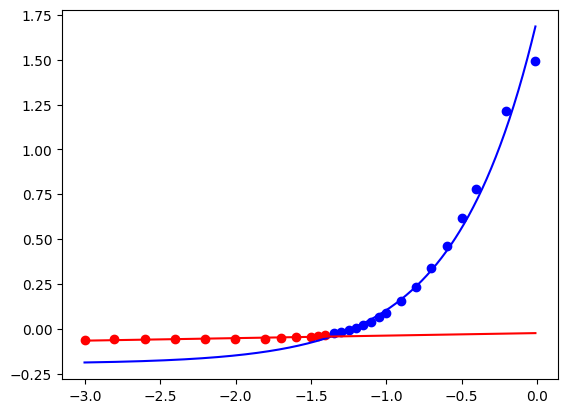

In [80]:
piecewise(x, y, sx, sy, 12, betaLin=[1,1,1], betaExp=[0,.5,1,-1.39], mark=True, print_beta=True)

## Plots

In [ ]:
fig, ax = plt.subplots(dpi=150)

ax.plot(x * 100, lorentzian_odr(output.beta, x),
         c='blue',
         linewidth=.8,
         label='Anpassung nach Lorentz',
         zorder=2)
ax.errorbar(plot_lense_x * 100, plot_lense_y,
            xerr=None, yerr=d_y_plot,
            capsize=4,
            ecolor='black',
            elinewidth=.6,
            capthick=.6,
            markersize=4, fmt="s",
            markeredgecolor='none', c="black",
            label='Intensität hinter Wachslinse',
            zorder=2)

ax.set_ylabel('$U$ [V]', fontsize=12)
ax.set_xlabel('$d$ [cm]', fontsize=12)
ax.set_xlim(45, 105)
ax.set_ylim(0.3, 0.75)

ax.axvline(output.beta[1] * 100,
           color='grey',
           linestyle='--',
           linewidth=0.8,
           label=f'Maximum bei $d={output.beta[1]*100:.2f}$ cm',
           zorder=1)

ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
plt.tick_params(which='minor',direction='in', labelsize=8, width=1, length=2)
plt.tick_params(which='major',direction='in', labelsize=12)

plt.legend(loc="upper left", bbox_to_anchor=(0.55, 0.25), fancybox=False, edgecolor='black', fontsize=9)
plt.show()

fig.savefig("/Users/danielmiksch/Downloads/plot_brennweite.pdf")